# Variational Autoencoder

In this assignment we will use the code from the Chollet textbook to build our own VAE model

The dataset is provided in '../resource/asnlib/publicdata/dataset/'. This is a set of images of famous people.

The goal is to see what output we can generate using a VAE on this dataset.

Also see the source code from Chollet that uses the MNIST dataset; code below is adapted from here:
https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/8.4-generating-images-with-vaes.ipynb

In [1]:
import keras
from keras import layers
from keras import backend as K
from keras.models import Model

from keras.backend.tensorflow_backend import set_session



import numpy as np
import os
from PIL import Image

from sklearn.model_selection import train_test_split
import tensorflow as tf

/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/usr/lib/python3.5/importlib/_bootstrap.py:222: RuntimeWarning: numpy.dtype size changed, may indicate binary

In [2]:
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.1  # Start with 10% of the GPU RAM
config.gpu_options.allow_growth = True                    # Dynamically grow the memory used on the GPU
sess = tf.Session() # config=config
set_session(sess)                                         # Set this TensorFlow session as the default session for Keras

## Load the data

In [3]:
PATH = '..//resource/asnlib/publicdata/dataset/'
file_base_names = list(os.walk(PATH))[0][2]

In [4]:
filenames = list(os.path.join(PATH, x) for x in file_base_names)

In [5]:
filenames[:10]

['..//resource/asnlib/publicdata/dataset/Andy_Roddick_0005.jpg',
 '..//resource/asnlib/publicdata/dataset/Paul_ONeill_0003.jpg',
 '..//resource/asnlib/publicdata/dataset/Aly_Wagner_0001.jpg',
 '..//resource/asnlib/publicdata/dataset/John_Howard_0008.jpg',
 '..//resource/asnlib/publicdata/dataset/Colin_Powell_0102.jpg',
 '..//resource/asnlib/publicdata/dataset/Scott_Fawell_0001.jpg',
 '..//resource/asnlib/publicdata/dataset/Ben_Curtis_0002.jpg',
 '..//resource/asnlib/publicdata/dataset/Peter_Sejna_0001.jpg',
 '..//resource/asnlib/publicdata/dataset/Venus_Williams_0008.jpg',
 '..//resource/asnlib/publicdata/dataset/Larry_Lucchino_0002.jpg']

# Load images into numpy array

In [6]:
imagedata_list = []
for file in filenames:
    ar = np.array(Image.open(file))
    imagedata_list.append(ar)

In [7]:
data = np.stack(imagedata_list)

In [8]:
data.shape

(1203, 250, 250, 3)

In [9]:
img_shape = (250, 250, 3)
batch_size = 32  # 16
latent_dim = 2  # Dimensionality of the latent space: a plane

input_img = keras.Input(shape=img_shape)

x = layers.Conv2D(32, 3,
                  padding='same', activation='relu')(input_img)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu',
                  strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)

z_mean = layers.Dense(latent_dim)(x)
z_log_var = layers.Dense(latent_dim)(x)

In [10]:
shape_before_flattening

(None, 16, 16, 64)

In [11]:
16*16*64, 14*14*64

(16384, 12544)

In [12]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim),
                              mean=0., stddev=1.)
    return z_mean + K.exp(z_log_var) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_var])

In [13]:
# This is the input where we will feed `z`.
decoder_input = layers.Input(K.int_shape(z)[1:])

# Upsample to the correct number of units
x = layers.Dense(np.prod(shape_before_flattening[1:]),
                 activation='relu')(decoder_input)

# Reshape into an image of the same shape as before our last `Flatten` layer
x = layers.Reshape(shape_before_flattening[1:])(x)

## Below is a sample decoding stack of deconvolutional layers. 

It is different from the one in the original Chollet code because the image sizes are different.

### TODO (optional): Experiment with the decoding network architecture; try to improve it.

In [14]:
#TODO: Improve this architecture.

# We then apply then reverse operation to the initial
# stack of convolution layers: `Conv2DTranspose` layers
# with corresponding parameters.
x = layers.Conv2DTranspose(64, 3,
                           padding='same', activation='relu',
                           strides=(2, 2))(x)

x = layers.Conv2D(64, 3,
                  padding='same', activation='sigmoid')(x)

x = layers.Conv2DTranspose(64, 3,
                           padding='same', activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='sigmoid')(x)

x = layers.Conv2DTranspose(64, 3,
                           padding='same', activation='relu',
                           strides=(2, 2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='sigmoid')(x)

x = layers.Conv2DTranspose(32, 3,
                           padding='same', activation='relu',
                           strides=(2, 2))(x)

# Hack: the size got too big; the following layers make it a little smaller until the output is the same size as the input.
# Consider better ways to get the sizes to line up.
x = layers.Conv2D(32, 3,
                  padding='valid', activation='sigmoid')(x)
x = layers.Conv2D(32, 3,
                  padding='valid', activation='sigmoid')(x)
x = layers.Conv2D(3, 3,
                  padding='valid', activation='sigmoid')(x)

# We end up with a feature map of the same size as the original input.

# This is our decoder model.
decoder = Model(decoder_input, x)

# We then apply it to `z` to recover the decoded `z`.
z_decoded = decoder(z)

In [15]:
class CustomVariationalLayer(keras.layers.Layer):

    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        xent_loss = keras.metrics.binary_crossentropy(x, z_decoded)
        kl_loss = -5e-4 * K.mean(
            1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        return K.mean(xent_loss + kl_loss)

    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        # We don't use this output.
        return x

# We call our custom layer on the input and the decoded output,
# to obtain the final model output.
y = CustomVariationalLayer()([input_img, z_decoded])

In [16]:
vae = Model(input_img, y)
#vae.compile(optimizer='rmsprop', loss=None)
optimizer = keras.optimizers.Adam(lr=0.001)
vae.compile(optimizer=optimizer, loss=None)
vae.summary()

# Train the VAE on MNIST digits
train, test = train_test_split(data)

train = train.astype('float32') / 255.
test = test.astype('float32') / 255.


/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:4: UserWarning: Output "custom_variational_layer_1" missing from loss dictionary. We assume this was done on purpose, and we will not be expecting any data to be passed to "custom_variational_layer_1" during training.
  after removing the cwd from sys.path.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 250, 250, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 250, 250, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 125, 125, 64) 18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 125, 125, 64) 36928       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

In [17]:
vae.fit(x=train, y=None,
        shuffle=True,
        epochs=50,
        batch_size=batch_size,
        validation_data=(test, None))

Train on 902 samples, validate on 301 samples
Epoch 1/50
902/902 [==============================] - 49s 54ms/step - loss: 0.6622 - val_loss: 0.6585
Epoch 2/50
902/902 [==============================] - 34s 38ms/step - loss: 0.6544 - val_loss: 0.6563
Epoch 3/50
902/902 [==============================] - 34s 38ms/step - loss: 0.6537 - val_loss: 0.6559
Epoch 4/50
902/902 [==============================] - 34s 38ms/step - loss: 0.6538 - val_loss: 0.6578
Epoch 5/50
902/902 [==============================] - 34s 38ms/step - loss: 0.6541 - val_loss: 0.6581
Epoch 6/50
902/902 [==============================] - 34s 38ms/step - loss: 0.6543 - val_loss: 0.6566
Epoch 7/50
902/902 [==============================] - 34s 38ms/step - loss: 0.6539 - val_loss: 0.6560
Epoch 8/50
902/902 [==============================] - 35s 38ms/step - loss: 0.6539 - val_loss: 0.6559
Epoch 9/50
902/902 [==============================] - 35s 38ms/step - loss: 0.6540 - val_loss: 0.6562
Epoch 10/50
902/902 [===============

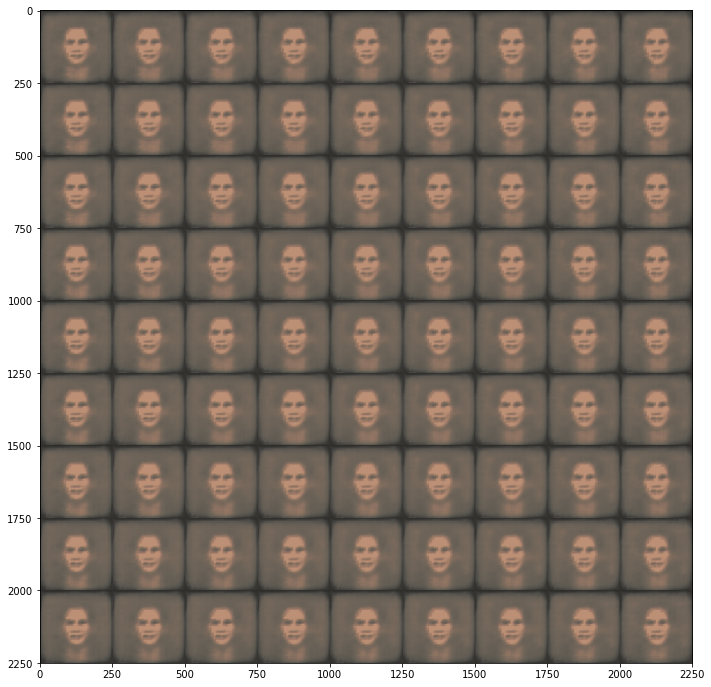

In [18]:
import matplotlib.pyplot as plt
from scipy.stats import norm

# Display a 2D manifold of the digits
n = 9  # figure with 15x15 digits
digit_size = 250
figure = np.zeros((digit_size * n, digit_size * n, 3))
# Linearly spaced coordinates on the unit square were transformed
# through the inverse CDF (ppf) of the Gaussian
# to produce values of the latent variables z,
# since the prior of the latent space is Gaussian
grid_x = norm.ppf(np.linspace(0.05, 0.95, n))
grid_y = norm.ppf(np.linspace(0.05, 0.95, n))

for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi]])
        z_sample = np.tile(z_sample, batch_size).reshape(batch_size, 2)
        x_decoded = decoder.predict(z_sample, batch_size=batch_size)
        digit = x_decoded[0].reshape(digit_size, digit_size, 3)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size, :] = digit

plt.figure(figsize=(12, 12))
plt.imshow(figure)
plt.show()

## Question 1
Examine the results. What does the x-dimension of the latent space represent? What does the y-dimension represent?

X and Y dimensions are the dimensionality of the output of Variational autoencoder. The VAE's encoder takes an input images of size 250 * 250* 3 and outputs a latent vector of a plane with x and y dimensions. It creates a latent vector of size 16 * 16 with 64 channels

## Question 2
What does the y-dimension represent?

It creates a latent vector of size 16 * 16 with 64 channels. Y-dimension represents the features of the human faces

## Question 3
Comment on the results. How did they turn out? Did anything surprise you?

The displayed images looks the same to me. I tried two times, both times, the images looks the same, not even a slight variation. I want to try more times and with different inputs, however due to the resource availability I limit myself only to two times.